In [1]:
import numpy as np
import pandas as pd 
from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier 
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
%matplotlib inline
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt
import scipy.stats
from itertools import combinations
from scipy.spatial.distance import euclidean
import math

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
AugTest = "../streetview/testAug.csv"

In [3]:
augData = pd.read_csv(AugTest)

In [4]:
len(list(set(augData['key'])))

601

In [5]:
Data = augData.drop(augData.index[0])

In [6]:
len(list(set(Data['key'])))

600

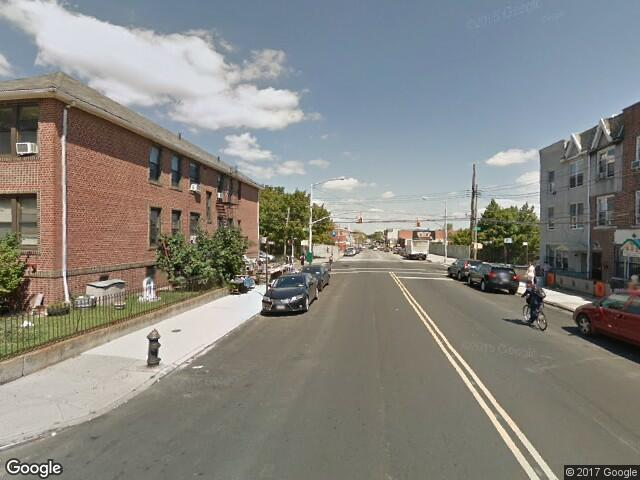

In [7]:
Image(Data.iloc[511]['path'])

In [27]:
import caffe
import sys
import os

import random
import numpy as np
from numpy import (array, dot, arccos, clip)
from numpy.linalg import norm

import cv2


# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

model_root = "/datasets_1/sagarj/BellLabs/caffe_models/places/"

imagenet_mean = model_root + 'places205CNN_mean.binaryproto'

meanFile = "/datasets_1/sagarj/BellLabs/Data/places205CNN_mean.npy"

logfile = "../Data/PlacesFeatExtractStreetview.txt"


#Size of images
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
NCHANNELS = 3
meanR = 105.487823486
meanG = 113.741088867
meanB = 116.060394287

meanMat = np.zeros((NCHANNELS,IMAGE_WIDTH,IMAGE_HEIGHT))
meanMat[0,:,:].fill(meanR)
meanMat[1,:,:].fill(meanG)
meanMat[2,:,:].fill(meanB)
#227

def transform_img(img, img_width=IMAGE_WIDTH, img_height=IMAGE_HEIGHT):

    #Histogram Equalization
    img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
    img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])

    #Image Resizing
    img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)

    return img


def predictImage(imgPath , net, transformer):
    

    path = imgPath.strip()
    im = caffe.io.load_image(path)
    net.blobs['data'].data[...] = transformer.preprocess('data', im)
    net.forward()
    #out1 = net.blobs['prob'].data
    out2 = net.blobs['fc7'].data
    #print(out2.shape)
    #out = np.concatenate((out1,out2.reshape(1,-1)),axis =1)
    out = out2
    #print(out.shape)
    return out


    
def getFeatMatrix(Data , disp ):
    caffe.set_mode_gpu()    
    #model_def = model_root + 'places205CNN_deploy_upgraded.prototxt'#'test.prototxt'
    #model_weights = model_root +'places205CNN_iter_300000_upgraded.caffemodel'#'caffe_sentibank_train_iter_250000'
    model_def = model_root + 'places205VGG16/deploy_10.prototxt'
    model_weights = model_root +'places205VGG16/snapshot_iter_765280.caffemodel'
    net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

    net.blobs['data'].reshape(1,3,IMAGE_WIDTH,IMAGE_HEIGHT)
    
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape}) 
    transformer.set_transpose('data', (2,0,1))
    transformer.set_channel_swap('data', (2,1,0))
    transformer.set_raw_scale('data', 255.0)
    #mean = np.load(meanFile)
    #print mean.shape
    feats = {}
    for index, row in Data.iterrows():
        if row['disp'] == disp:
            #featArray = predictImage(row['path'] , NN , TFormer)
            imgPath = row['path']
            #print imgPath
            path = imgPath.strip()
            if not os.path.exists(path):
                featArray = np.zeros((1,4096))
            else:
                im = transformer.preprocess('data',caffe.io.load_image(path))
                net.blobs['data'].data[...] = im - meanMat
                net.forward()
                featArray = net.blobs['fc7'].data.copy()
                
            subkey = row['path'].strip().split('/')[-1].split('.')[0]
            if row['key'] not in feats.keys():
                feats[row['key']] = {}
                feats[row['key']][subkey] = featArray
            else:
                feats[row['key']][subkey] = featArray
    return feats

In [28]:
feats_0meters = getFeatMatrix(Data , 0 )
        

In [30]:
feats_20meters = getFeatMatrix(Data , 1 )

In [31]:
feats_40meters = getFeatMatrix(Data , 2 )


In [32]:
feats_60meters = getFeatMatrix(Data , 3 )

In [33]:
feats_60meters.keys()[10]

'513d6ad3fdc9f03587004b7e'

In [34]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)


def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u.flatten(), v2_u.flatten()), -1.0, 1.0))

def metric(v1,v2):
    dist = angle_between(v1,v2)
    return dist

def findSimRatio(featsDict):
    ratios = []
    for k in featsDict.keys():
        keys = featsDict[k].keys()
        #print k
        intraDist = []
        for combo in combinations(keys, 2):
            v1 = featsDict[k][combo[0]]
            v2 = featsDict[k][combo[1]]
            #intraDist.append(euclidean(featsDict[k][combo[0]] , featsDict[k][combo[1]] ))
            if np.isnan(metric(v1,v2)):
                intraDist.append(3.14)
            else:
                intraDist.append(metric( v1, v2 ))
        
        #print intraDist
        samples = random.sample(featsDict.keys(),6)
        #print samples
        interDist = []
        for s in samples:
            i1 = random.sample(featsDict[k].keys() , 1)
            v1 = featsDict[k][i1[0]]
            i2 = random.sample(featsDict[s].keys() , 1)
            v2 = featsDict[s][i2[0]]
            #interDist.append(euclidean( v1, v2 ))
            if np.isnan(metric(v1,v2)):
                interDist.append(3.14)
            else:
                interDist.append(metric( v1, v2 ))
        #print interDist
        ratios.append(float(np.median(intraDist))/np.median(interDist))
    return ratios , intraDist


In [35]:
a = feats_0meters['513d6b26fdc9f03587004c55']['513d6b26fdc9f03587004c5500_0']
b = feats_0meters['513d9d2efdc9f03587007fab']['513d9d2efdc9f03587007fab00_0']
metric(a,b)

1.2044034

In [36]:
ratios0Meters , intraDist0 = findSimRatio(feats_0meters)

In [37]:
ratios20Meters , intraDist20 = findSimRatio(feats_20meters)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
ratios40Meters , intraDist40 = findSimRatio(feats_40meters)

In [39]:
ratios60Meters , intraDist60 = findSimRatio(feats_60meters)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in divide


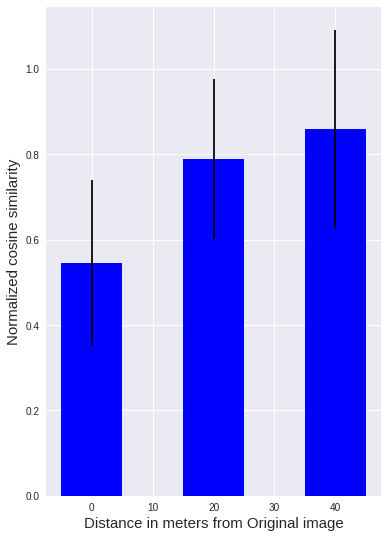

In [41]:
ind = [0 , 20 , 40 , 60 ]
width = 10       # the width of the bars

dist_medians = [np.median(ratios0Meters) , np.median(ratios20Meters) , np.median(ratios40Meters) , np.median(ratios60Meters)]
dist_std = [np.std(ratios0Meters) , np.std(ratios20Meters) , np.std(ratios40Meters ) , np.std(ratios60Meters)]
fig, ax = plt.subplots()
fig.set_size_inches(6,9)
plt.xlabel("Distance in meters from Original image" , fontsize = 15)
plt.ylabel("Normalized cosine similarity" , fontsize = 15 )
rects1 = ax.bar(ind, dist_medians, width, color='b', yerr=dist_std)

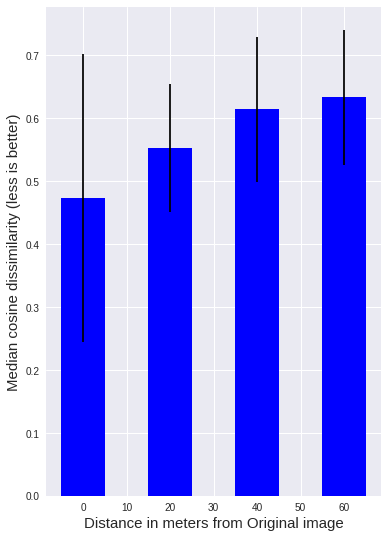

In [42]:
ind = [0 , 20 , 40 , 60 ]
width = 10       # the width of the bars

dist_medians = [np.median(intraDist0) , np.median(intraDist20) , np.median(intraDist40) , np.median(intraDist60)]
dist_std = [np.std(intraDist0) , np.std(intraDist20) , np.std(intraDist40 ) , np.std(intraDist60)]
fig, ax = plt.subplots()
fig.set_size_inches(6,9)
plt.xlabel("Distance in meters from Original image" , fontsize = 15)
plt.ylabel("Median cosine dissimilarity (less is better)" , fontsize = 15 )
# fig.xlabel("Distance in meters for the augmented image" )
rects1 = ax.bar(ind, dist_medians, width, color='b', yerr=dist_std)